### Imports

In [1]:
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import time, timedelta, datetime

In [3]:
import json

In [4]:
client = MlflowClient()

In [5]:
def cast_to_datetime(seconds):
    # Convierte los segundos en horas, minutos y segundos
    seconds = round(seconds)
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    # Crea un objeto time con estos valores
    return time(hour=hours, minute=minutes, second=seconds)

In [6]:
def pass_thru(value):
    return value

def get_metric_info(run_id, key, x_type = "numeric", y_type="numeric"):
    metric_history = client.get_metric_history(run_id, key)
    metric_values = [metric.value for metric in metric_history]
    metric_steps = [metric.step for metric in metric_history]
    avg_metric = sum(metric_values) / len(metric_values)


    if y_type == "time":
        avg_metric = cast_to_datetime(avg_metric)
    print(avg_metric)
    

In [7]:
def plot_metric(run_id, key, x_label, y_label, title, file_name):
    metric_history = client.get_metric_history(run_id, key)
    metric_values = [metric.value for metric in metric_history]
    metric_steps = [metric.step for metric in metric_history]

    # Crear la figura y el gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(metric_steps, metric_values, color="#F80044", linewidth=2, alpha=0.8)

    # Etiquetas y título
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Mostrar la cuadrícula
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.savefig(file_name, format='png', dpi=300, bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()

    

## Obtener experimento de pre-entrenamiento

In [8]:
mlflow.set_tracking_uri("http://localhost:5000")

## Experimento 2

#### Ajuste fino

In [9]:
experiment = mlflow.get_experiment_by_name("Fine-tuning")

In [10]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [11]:
exp1 = runs[runs["tags.mlflow.runName"] ==  "indecisive-ant-714"]

In [14]:
exp1

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_class_3,metrics.recall_class_16,metrics.recall_class_15,metrics.recall_class_14,...,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.pretrain_run_name,tags.pretrain_run_id,tags.mlflow.note.content,tags.pretrain
55,d3ab6889602a431ab7598d79c74b6863,278242996031726872,FINISHED,file:///opt/code/mlruns/278242996031726872/d3a...,2024-08-28 12:55:13.821000+00:00,2024-08-28 23:11:09.630000+00:00,NaN,NaN,NaN,NaN,...,95db408ab22d3c5c9084988bc20297a2d8997122,root,timert_cli.py,LOCAL,None,indecisive-ant-714,gregarious-worm-576,07d71440248f4ed88b2d20a79725c795,Reemplazo del seleccionado.,None


In [15]:
run_id = exp1.iloc[0].run_id

In [16]:
run_id

'd3ab6889602a431ab7598d79c74b6863'

In [17]:
exp_id = exp1.iloc[0].experiment_id

In [18]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

6.161643835616439


In [19]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

4078.598630136986


In [20]:
get_metric_info(run_id, "system/gpu_2_utilization_percentage")

47.31506849315068


In [21]:
get_metric_info(run_id, "system/gpu_2_memory_usage_megabytes")

2964.0958904109575


In [22]:
get_metric_info(run_id, "system/gpu_2_power_usage_watts")

109.4054794520548


##### Gráfica de clasificadores

In [23]:
exp_id

'278242996031726872'

In [24]:
all_runs_exp2 = client.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{run_id}'"
)

In [25]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy'],
                    subrun.data.metrics['test_balanced_accuracy']*100] for subrun in all_runs_exp2 if 'test_accuracy' in subrun.data.metrics]

In [26]:
run_names = [item[0] for item in test_accuracies]
test_accuracy_values = [item[1] for item in test_accuracies]
test_balanced_accuracy_values = [item[2] for item in test_accuracies]

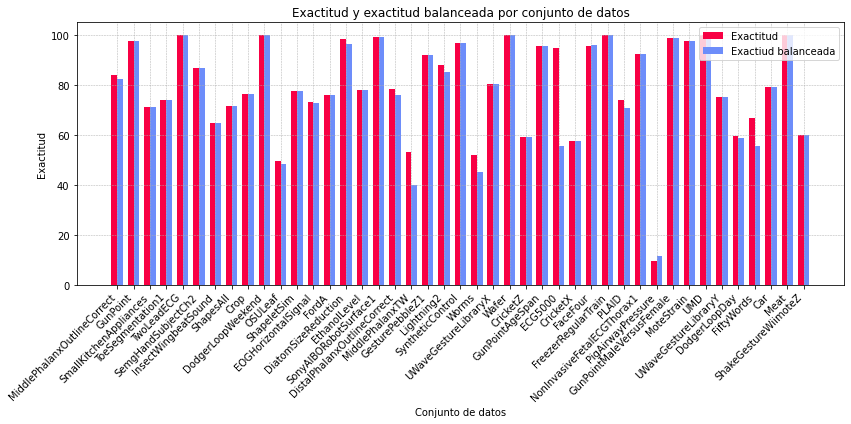

In [27]:
# Número de grupos
n_groups = len(run_names)

# Crear posiciones para las barras
index = np.arange(n_groups)
bar_width = 0.35

# Crear la figura
plt.figure(figsize=(12, 6))

# Colores
colors = ['#F80044', '#6d8dfa']

# Hachuras para las texturas
hatch_patterns = ['///|||', '---+++']  # Hachuras diferentes para cada conjunto de barras

# Gráfica de barras para test_accuracy
plt.bar(index, test_accuracy_values, bar_width, color=colors[0], label='Exactitud')

# Gráfica de barras para test_balanced_accuracy
plt.bar(index + bar_width, test_balanced_accuracy_values, bar_width, color=colors[1], label='Exactiud balanceada')

# Configuración de las etiquetas y título
plt.xlabel('Conjunto de datos')
plt.ylabel('Exactitud')
plt.title('Exactitud y exactitud balanceada por conjunto de datos')
plt.xticks(index + bar_width / 2, run_names, rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("exactitud-exp2.png", format='png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [28]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp2:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_balanced_accuracy"])
print(sum(f1s) / len(f1s)*100)

77.92941703377227


In [29]:
## Exactitud f1 micro
f1s = []
for run in all_runs_exp2:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_f1_micro"])
print(sum(f1s) / len(f1s)*100)

79.74125094652182


## Experimento 1

#### Pre-entrenamiento

In [30]:
experiment = mlflow.get_experiment_by_name("Pre-train")

In [31]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [32]:
exp1= runs[runs["tags.mlflow.runName"] == "gregarious-worm-576"]

In [33]:
exp1

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.total_training_time,metrics.epoch_time,metrics.average_loss,metrics.best_loss,...,params.aditional_loss_function,params.valid_frac,params.test_frac,tags.mlflow.log-model.history,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.note.content
15,07d71440248f4ed88b2d20a79725c795,489730860219751947,FINISHED,file:///opt/code/mlruns/489730860219751947/07d...,2024-08-18 13:56:18.848000+00:00,2024-08-19 05:02:39.731000+00:00,1.724044e+09,380.242429,0.042371,0.042256,...,L1Loss(),0.1,0.1,"[{""run_id"": ""07d71440248f4ed88b2d20a79725c795""...",995b1db9ec141e53e944119d790943eaa895bc1c,root,LOCAL,timert_cli.py,gregarious-worm-576,"El modelo base de referencia, entrenado con lo..."


In [34]:
run_id = exp1.iloc[0].run_id

#### Obtener conjuntos de métricas

In [35]:
get_metric_info(run_id, "epoch_time", y_type="time")

00:02:16


In [36]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

5.542211055276348


In [37]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

3966.983249581241


In [38]:
get_metric_info(run_id, "system/gpu_3_utilization_percentage")

63.76046901172529


In [39]:
get_metric_info(run_id, "system/gpu_3_memory_usage_megabytes")

3579.198324958096


In [40]:
get_metric_info(run_id, "system/gpu_3_power_usage_watts")

140.88860971524295


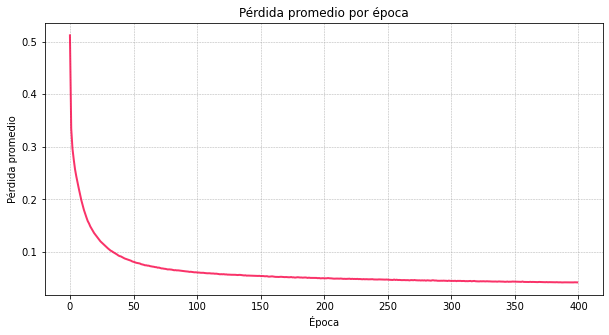

In [41]:
plot_metric(run_id, "average_loss", "Época", "Pérdida promedio", "Pérdida promedio por época", "loos_train_exp2.png")

#### Ajuste fino

In [42]:
experiment = mlflow.get_experiment_by_name("Fine-tuning")

In [43]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [44]:
exp1 = runs[runs["tags.mlflow.runName"] ==  "youthful-boar-759"]

In [45]:
exp1

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_class_3,metrics.recall_class_16,metrics.recall_class_15,metrics.recall_class_14,...,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.pretrain_run_name,tags.pretrain_run_id,tags.mlflow.note.content,tags.pretrain
101,d885f3ef83c14f54851b3b2b32b321c3,278242996031726872,FINISHED,file:///opt/code/mlruns/278242996031726872/d88...,2024-08-27 13:07:44.168000+00:00,2024-08-27 20:39:36.825000+00:00,NaN,NaN,NaN,NaN,...,87f0ecdc670444582b2d4560d2476503969e71df,root,timert_cli.py,LOCAL,None,youthful-boar-759,gregarious-worm-576,07d71440248f4ed88b2d20a79725c795,parámetros congelados,None


In [46]:
run_id = exp1.iloc[0].run_id

In [47]:
exp_id = exp1.iloc[0].experiment_id

In [48]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

4.474074074074073


In [49]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

3643.4370370370375


In [50]:
get_metric_info(run_id, "system/gpu_3_utilization_percentage")

22.48148148148148


In [51]:
get_metric_info(run_id, "system/gpu_3_memory_usage_megabytes")

1332.737037037037


In [52]:
get_metric_info(run_id, "system/gpu_3_power_usage_watts")

76.72407407407407


##### Gráfica de clasificadores

In [53]:
exp_id

'278242996031726872'

In [54]:
all_runs_exp1 = client.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{run_id}'"
)

In [55]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy'],
                    subrun.data.metrics['test_balanced_accuracy']*100] for subrun in all_runs_exp1 if 'test_accuracy' in subrun.data.metrics]

In [56]:
test_accuracies

[['GunPointOldVersusYoung', 46.15384615384615, 48.837209302325576],
 ['Beef', 33.33333333333333, 33.33333333333333],
 ['MiddlePhalanxOutlineCorrect', 62.01117318435754, 50.0],
 ['GunPoint', 50.0, 50.0],
 ['SmallKitchenAppliances', 34.66666666666667, 34.66666666666667],
 ['ToeSegmentation1', 42.592592592592595, 41.620879120879124],
 ['TwoLeadECG', 53.21888412017167, 53.031977600943115],
 ['SemgHandSubjectCh2', 13.333333333333334, 13.333333333333334],
 ['InsectWingbeatSound', 9.318181818181818, 9.318181818181817],
 ['ShapesAll', 2.9166666666666665, 2.9166666666666665],
 ['Crop', 3.1875, 3.1875],
 ['DodgerLoopWeekend', 28.125, 50.0],
 ['OSULeaf', 12.359550561797752, 14.655067155067156],
 ['ShapeletSim', 50.0, 50.0],
 ['EOGHorizontalSignal', 4.827586206896552, 4.700854700854701],
 ['FordA', 50.76142131979695, 49.8415671647949],
 ['DiatomSizeReduction', 27.692307692307693, 22.5],
 ['EthanolLevel', 24.875621890547265, 25.0],
 ['SonyAIBORobotSurface1', 44.0, 50.0],
 ['DistalPhalanxOutlineCorr

In [57]:
run_names = [item[0] for item in test_accuracies]
test_accuracy_values = [item[1] for item in test_accuracies]
test_balanced_accuracy_values = [item[2] for item in test_accuracies]

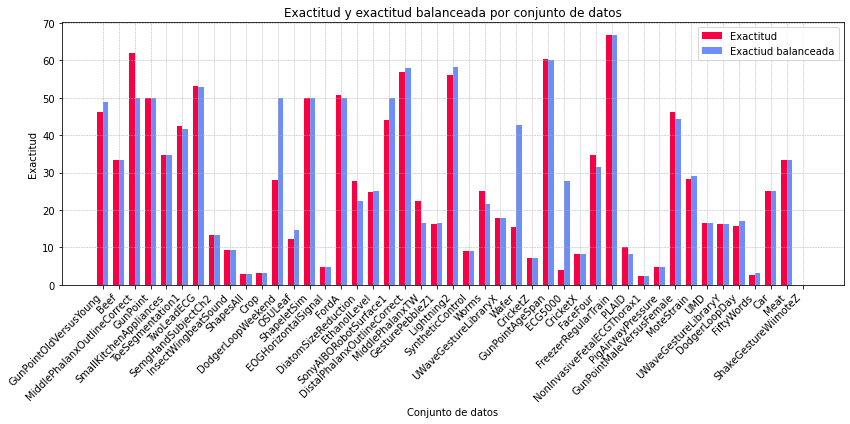

In [58]:
# Número de grupos
n_groups = len(run_names)

# Crear posiciones para las barras
index = np.arange(n_groups)
bar_width = 0.35

# Crear la figura
plt.figure(figsize=(12, 6))

# Colores
colors = ['#F80044', '#6d8dfa']

# Hachuras para las texturas
hatch_patterns = ['///|||', '---+++']  # Hachuras diferentes para cada conjunto de barras

# Gráfica de barras para test_accuracy
plt.bar(index, test_accuracy_values, bar_width, color=colors[0], label='Exactitud')

# Gráfica de barras para test_balanced_accuracy
plt.bar(index + bar_width, test_balanced_accuracy_values, bar_width, color=colors[1], label='Exactiud balanceada')

# Configuración de las etiquetas y título
plt.xlabel('Conjunto de datos')
plt.ylabel('Exactitud')
plt.title('Exactitud y exactitud balanceada por conjunto de datos')
plt.xticks(index + bar_width / 2, run_names, rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("exactitud-exp1.png", format='png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [59]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp1:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_balanced_accuracy"])
print(sum(f1s) / len(f1s)*100)

27.776469365259253


In [60]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp1:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_f1_micro"])
print(sum(f1s) / len(f1s)*100)

23.145096128643775


## Experimento 3

#### Pre-entrenamiento

In [61]:
experiment = mlflow.get_experiment_by_name("Pre-train")

In [62]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [63]:
exp3= runs[runs["tags.mlflow.runName"] == "masked-turtle-959"]

In [64]:
exp3

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.total_training_time,metrics.epoch_time,metrics.average_loss,metrics.best_loss,...,params.aditional_loss_function,params.valid_frac,params.test_frac,tags.mlflow.log-model.history,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.note.content
10,d5cbf6b2fb0f435da0f5c2bd1b991acc,489730860219751947,FINISHED,file:///opt/code/mlruns/489730860219751947/d5c...,2024-08-24 19:16:36.766000+00:00,2024-08-25 11:25:34.258000+00:00,58078.835167,95.048328,0.042418,0.042418,...,None,None,None,"[{""run_id"": ""d5cbf6b2fb0f435da0f5c2bd1b991acc""...",42daa673aa99fe7670284fed358788d46c2d2912,root,LOCAL,timert_cli.py,masked-turtle-959,Cambio de parámetro para que ahora en las capa...


In [65]:
run_id = exp3.iloc[0].run_id

#### Obtener conjuntos de métricas

In [66]:
get_metric_info(run_id, "epoch_time", y_type="time")

00:02:25


In [67]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

15.345833333333333


In [68]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

9795.914583333335


In [69]:
get_metric_info(run_id, "system/gpu_2_utilization_percentage")

62.645833333333336


In [70]:
get_metric_info(run_id, "system/gpu_2_memory_usage_megabytes")

3545.798958333331


In [71]:
get_metric_info(run_id, "system/gpu_2_power_usage_watts")

116.11458333333336


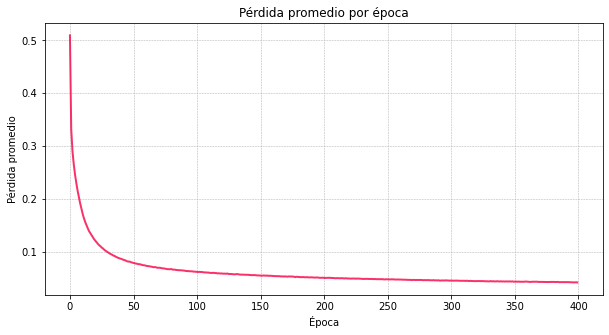

In [72]:
plot_metric(run_id, "average_loss", "Época", "Pérdida promedio", "Pérdida promedio por época", "loos_train_exp3.png")

#### Ajuste fino

In [73]:
experiment = mlflow.get_experiment_by_name("Fine-tuning")

In [74]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [75]:
exp3 = runs[runs["tags.mlflow.runName"] ==  "traveling-dog-615"]

In [76]:
exp3

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_class_3,metrics.recall_class_16,metrics.recall_class_15,metrics.recall_class_14,...,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.pretrain_run_name,tags.pretrain_run_id,tags.mlflow.note.content,tags.pretrain
304,8976c43d0e764229a36960c40d9bacf4,278242996031726872,FINISHED,file:///opt/code/mlruns/278242996031726872/897...,2024-08-25 18:32:56.233000+00:00,2024-08-26 05:55:51.239000+00:00,NaN,NaN,NaN,NaN,...,082154634b0f7a6f5b922eae1fbb1d49b208a9b2,root,timert_cli.py,LOCAL,None,traveling-dog-615,masked-turtle-959,d5cbf6b2fb0f435da0f5c2bd1b991acc,None,None


In [77]:
run_id = exp3.iloc[0].run_id

In [78]:
exp_id = exp3.iloc[0].experiment_id

In [79]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

9.911111111111111


In [80]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

8469.196296296299


In [81]:
get_metric_info(run_id, "system/gpu_2_utilization_percentage")

45.65432098765432


In [82]:
get_metric_info(run_id, "system/gpu_2_memory_usage_megabytes")

2949.2444444444445


In [83]:
get_metric_info(run_id, "system/gpu_2_power_usage_watts")

97.24567901234566


##### Gráfica de clasificadores

In [84]:
exp_id

'278242996031726872'

In [85]:
all_runs_exp3 = client.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{run_id}'"
)

In [86]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy'],
                    subrun.data.metrics['test_balanced_accuracy']*100] for subrun in all_runs_exp3 if 'test_accuracy' in subrun.data.metrics]

In [87]:
test_accuracies

[['GunPointOldVersusYoung', 93.4065934065934, 93.14437984496125],
 ['Beef', 83.33333333333334, 80.0],
 ['MiddlePhalanxOutlineCorrect', 84.91620111731844, 82.9954954954955],
 ['GunPoint', 97.5, 97.5],
 ['SmallKitchenAppliances', 69.33333333333334, 69.33333333333334],
 ['ToeSegmentation1', 75.92592592592592, 75.68681318681318],
 ['TwoLeadECG', 100.0, 100.0],
 ['SemgHandSubjectCh2', 91.66666666666666, 91.66666666666667],
 ['InsectWingbeatSound', 61.36363636363637, 61.36363636363637],
 ['ShapesAll', 75.0, 75.0],
 ['Crop', 74.79166666666667, 74.79166666666667],
 ['DodgerLoopWeekend', 100.0, 100.0],
 ['OSULeaf', 62.92134831460674, 61.043058248940596],
 ['ShapeletSim', 55.00000000000001, 55.00000000000001],
 ['EOGHorizontalSignal', 71.72413793103448, 71.5811965811966],
 ['FordA', 73.90862944162436, 73.81938656786619],
 ['DiatomSizeReduction', 100.0, 100.0],
 ['EthanolLevel', 54.72636815920397, 54.58823529411765],
 ['SonyAIBORobotSurface1', 97.6, 97.27272727272727],
 ['DistalPhalanxOutlineCorr

In [88]:
run_names = [item[0] for item in test_accuracies]
test_accuracy_values = [item[1] for item in test_accuracies]
test_balanced_accuracy_values = [item[2] for item in test_accuracies]

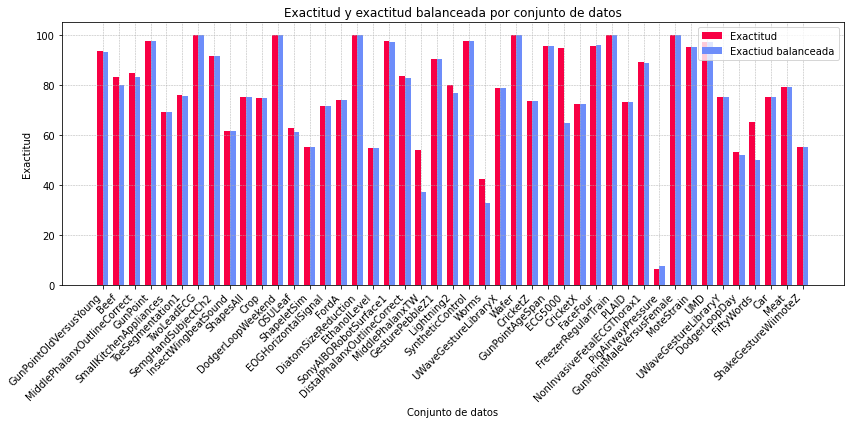

In [89]:
# Número de grupos
n_groups = len(run_names)

# Crear posiciones para las barras
index = np.arange(n_groups)
bar_width = 0.35

# Crear la figura
plt.figure(figsize=(12, 6))

# Colores
colors = ['#F80044', '#6d8dfa']

# Hachuras para las texturas
hatch_patterns = ['///|||', '---+++']  # Hachuras diferentes para cada conjunto de barras

# Gráfica de barras para test_accuracy
plt.bar(index, test_accuracy_values, bar_width, color=colors[0], label='Exactitud')

# Gráfica de barras para test_balanced_accuracy
plt.bar(index + bar_width, test_balanced_accuracy_values, bar_width, color=colors[1], label='Exactiud balanceada')

# Configuración de las etiquetas y título
plt.xlabel('Conjunto de datos')
plt.ylabel('Exactitud')
plt.title('Exactitud y exactitud balanceada por conjunto de datos')
plt.xticks(index + bar_width / 2, run_names, rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("exactitud-exp3.png", format='png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [90]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp3:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_balanced_accuracy"])
print(sum(f1s) / len(f1s)*100)

76.9211601868598


In [91]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp3:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_f1_micro"])
print(sum(f1s) / len(f1s)*100)

78.35707532316421


## Experimento 4

#### Pre-entrenamiento

In [92]:
experiment = mlflow.get_experiment_by_name("Pre-train")

In [93]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [94]:
exp4= runs[runs["tags.mlflow.runName"] == "masked-bird-8"]

In [95]:
exp4

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.total_training_time,metrics.epoch_time,metrics.average_loss,metrics.best_loss,...,params.aditional_loss_function,params.valid_frac,params.test_frac,tags.mlflow.log-model.history,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.note.content
11,880b7adc9a244f31949f09a57d597f53,489730860219751947,FINISHED,file:///opt/code/mlruns/489730860219751947/880...,2024-08-24 19:13:58.374000+00:00,2024-08-25 11:33:14.662000+00:00,58697.966343,90.633059,0.182699,0.182699,...,None,None,None,"[{""run_id"": ""880b7adc9a244f31949f09a57d597f53""...",42daa673aa99fe7670284fed358788d46c2d2912,root,LOCAL,timert_cli.py,masked-bird-8,nueva mejora. el codificador posicional ahora ...


In [96]:
run_id = exp4.iloc[0].run_id

#### Obtener conjuntos de métricas

In [97]:
get_metric_info(run_id, "epoch_time", y_type="time")

00:02:27


In [98]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

15.29175257731959


In [99]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

9762.022680412372


In [100]:
get_metric_info(run_id, "system/gpu_3_utilization_percentage")

55.21649484536083


In [101]:
get_metric_info(run_id, "system/gpu_3_memory_usage_megabytes")

3566.967010309276


In [102]:
get_metric_info(run_id, "system/gpu_3_power_usage_watts")

123.76597938144329


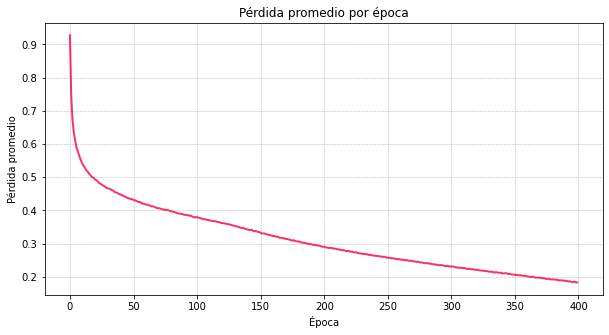

In [103]:
plot_metric(run_id, "average_loss", "Época", "Pérdida promedio", "Pérdida promedio por época", "loos_train_exp4.png")

#### Ajuste fino

In [104]:
experiment = mlflow.get_experiment_by_name("Fine-tuning")

In [105]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [106]:
exp4 = runs[runs["tags.mlflow.runName"] ==  "classy-lynx-584"]

In [107]:
exp4

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_class_3,metrics.recall_class_16,metrics.recall_class_15,metrics.recall_class_14,...,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.pretrain_run_name,tags.pretrain_run_id,tags.mlflow.note.content,tags.pretrain
302,246bcc1ddde64e13ad7a0d745819bb18,278242996031726872,FINISHED,file:///opt/code/mlruns/278242996031726872/246...,2024-08-25 18:33:00.497000+00:00,2024-08-26 05:31:30.075000+00:00,NaN,NaN,NaN,NaN,...,082154634b0f7a6f5b922eae1fbb1d49b208a9b2,root,timert_cli.py,LOCAL,None,classy-lynx-584,masked-bird-8,880b7adc9a244f31949f09a57d597f53,None,None


In [108]:
run_id = exp4.iloc[0].run_id

In [109]:
exp_id = exp4.iloc[0].experiment_id

In [110]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

10.087179487179485


In [111]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

8569.776923076925


In [112]:
get_metric_info(run_id, "system/gpu_3_utilization_percentage")

46.08974358974359


In [113]:
get_metric_info(run_id, "system/gpu_3_memory_usage_megabytes")

2968.746153846154


In [114]:
get_metric_info(run_id, "system/gpu_3_power_usage_watts")

112.80256410256409


##### Gráfica de clasificadores

In [115]:
exp_id

'278242996031726872'

In [116]:
all_runs_exp4 = client.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{run_id}'"
)

In [117]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy'],
                    subrun.data.metrics['test_balanced_accuracy']*100] for subrun in all_runs_exp4 if 'test_accuracy' in subrun.data.metrics]

In [118]:
test_accuracies

[['GunPointOldVersusYoung', 95.6043956043956, 95.34883720930232],
 ['Beef', 58.333333333333336, 53.333333333333336],
 ['MiddlePhalanxOutlineCorrect', 82.68156424581005, 79.76947535771066],
 ['GunPoint', 100.0, 100.0],
 ['SmallKitchenAppliances', 66.0, 66.0],
 ['ToeSegmentation1', 83.33333333333334, 83.24175824175823],
 ['TwoLeadECG', 100.0, 100.0],
 ['SemgHandSubjectCh2', 87.22222222222223, 87.22222222222221],
 ['InsectWingbeatSound', 62.272727272727266, 62.272727272727266],
 ['ShapesAll', 75.0, 75.0],
 ['Crop', 73.22916666666667, 73.22916666666669],
 ['DodgerLoopWeekend', 100.0, 100.0],
 ['OSULeaf', 59.55056179775281, 56.115240968182135],
 ['ShapeletSim', 97.5, 97.5],
 ['EOGHorizontalSignal', 73.79310344827587, 73.6111111111111],
 ['FordA', 77.66497461928934, 77.83755683365378],
 ['DiatomSizeReduction', 100.0, 100.0],
 ['EthanolLevel', 75.62189054726367, 75.61764705882352],
 ['SonyAIBORobotSurface1', 99.2, 99.0909090909091],
 ['DistalPhalanxOutlineCorrect', 77.27272727272727, 75.76252

In [119]:
run_names = [item[0] for item in test_accuracies]
test_accuracy_values = [item[1] for item in test_accuracies]
test_balanced_accuracy_values = [item[2] for item in test_accuracies]

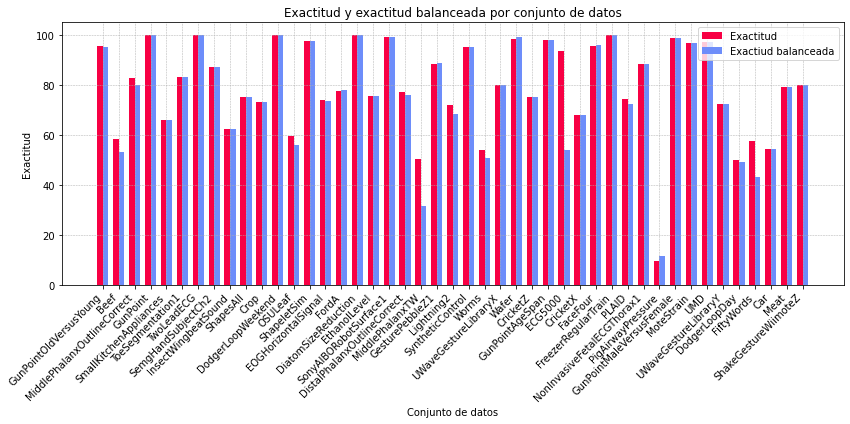

In [120]:
# Número de grupos
n_groups = len(run_names)

# Crear posiciones para las barras
index = np.arange(n_groups)
bar_width = 0.35

# Crear la figura
plt.figure(figsize=(12, 6))

# Colores
colors = ['#F80044', '#6d8dfa']

# Hachuras para las texturas
hatch_patterns = ['///|||', '---+++']  # Hachuras diferentes para cada conjunto de barras

# Gráfica de barras para test_accuracy
plt.bar(index, test_accuracy_values, bar_width, color=colors[0], label='Exactitud')

# Gráfica de barras para test_balanced_accuracy
plt.bar(index + bar_width, test_balanced_accuracy_values, bar_width, color=colors[1], label='Exactiud balanceada')

# Configuración de las etiquetas y título
plt.xlabel('Conjunto de datos')
plt.ylabel('Exactitud')
plt.title('Exactitud y exactitud balanceada por conjunto de datos')
plt.xticks(index + bar_width / 2, run_names, rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig("exactitud-exp4.png", format='png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [121]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp4:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_balanced_accuracy"])
print(sum(f1s) / len(f1s)*100)

77.29987446780356


In [122]:
## Exactitud balanceada
f1s = []
for run in all_runs_exp4:
    run_id = run.info.run_id
    # Acceder a las funciones de pérdida
    f1s.append(run.data.metrics["test_f1_micro"])
print(sum(f1s) / len(f1s)*100)

78.88780184503901


## Comparación de todos los experimentos

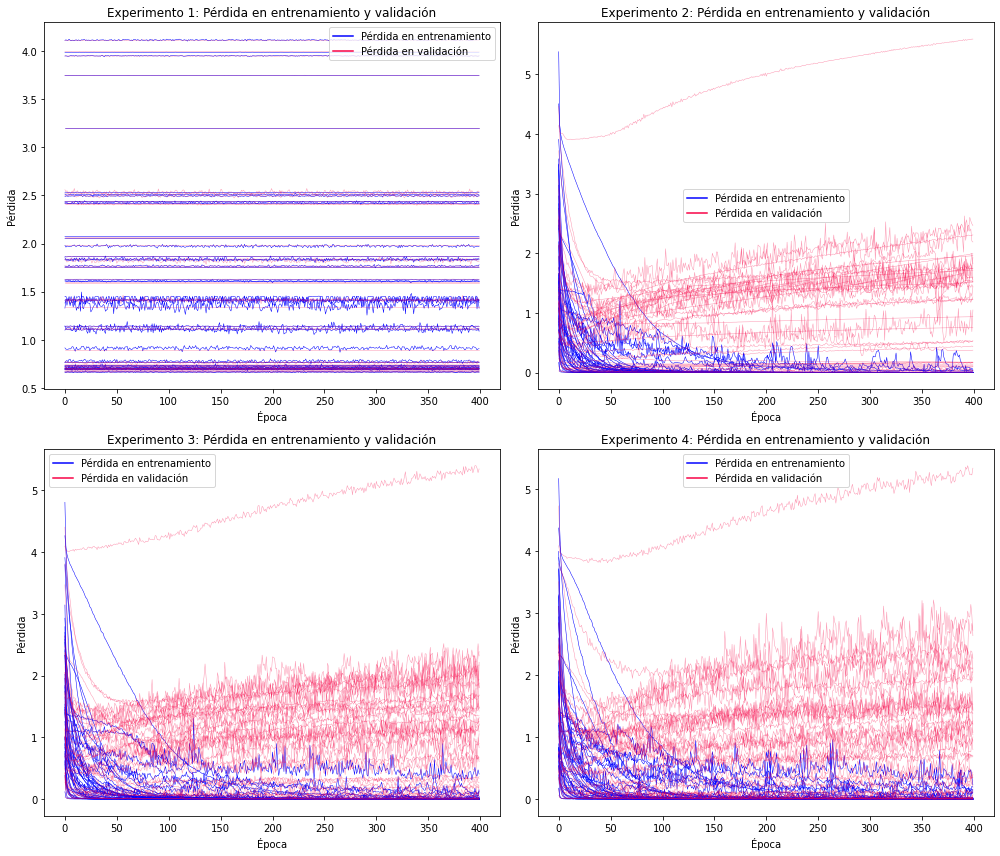

In [123]:
# Crear la figura y los subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2x2 grilla

# Lista de datasets a iterar
datasets = [all_runs_exp1, all_runs_exp2, all_runs_exp3, all_runs_exp4]
titles = ["Experimento 1", "Experimento 2", "Experimento 3", "Experimento 4"]

# Iterar sobre cada dataset y subplot correspondiente
for i, (runs, ax, title) in enumerate(zip(datasets, axs.ravel(), titles)):
    loss_train = []
    loss_val = []
    epocas = list(range(400))

    # Recolectar las pérdidas para entrenamiento y validación
    for run in runs:
        run_id = run.info.run_id

        metric_history = client.get_metric_history(run_id, "average_loss_train")
        loss_train.append([metric.value for metric in metric_history])
        metric_history = client.get_metric_history(run_id, "average_loss_validation")
        loss_val.append([metric.value for metric in metric_history])

    # Graficar todas las curvas de pérdida de entrenamiento en el subplot actual
    for loss in loss_train:
        ax.plot(epocas, loss, color='blue', linewidth=0.5)  # Azul para entrenamiento

    # Graficar todas las curvas de pérdida de evaluación en el subplot actual
    for loss in loss_val:
        ax.plot(epocas, loss, color='#F80044', alpha=0.4, linewidth=0.5)  # Rojo para validación

    # Configurar el subplot actual
    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida')
    ax.set_title(f'{title}: Pérdida en entrenamiento y validación')
    ax.plot([], [], color='blue', label='Pérdida en entrenamiento')
    ax.plot([], [], color='#F80044', label='Pérdida en validación')
    ax.legend()

# Ajustar layout para que no se superpongan
plt.tight_layout()
plt.savefig("loss-all-experiments.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

### Comparación con otros métodos

#### Time-CLR

In [124]:
timeclr = pd.read_csv("analysis_files/timeclr_results.csv", header=1)

In [125]:
timeclr.head()

,dataset,TimeCLR,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Adiac,0.7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ArrowHead,0.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beef,0.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BeetleFly,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BirdChicken,0.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
timeclr = timeclr[["dataset", "TimeCLR"]]

In [127]:
test_datasets_names = ['ShakeGestureWiimoteZ', 'Meat', 'Car', 'FiftyWords', 'DodgerLoopDay',
 'UWaveGestureLibraryY', 'UMD', 'MoteStrain', 'GunPointMaleVersusFemale',
 'PigAirwayPressure', 'NonInvasiveFetalECGThorax1', 'PLAID',
 'FreezerRegularTrain', 'FaceFour', 'CricketX', 'ECG5000', 'GunPointAgeSpan',
 'CricketZ', 'Wafer', 'UWaveGestureLibraryX', 'Worms', 'SyntheticControl',
 'Lightning2', 'GesturePebbleZ1', 'MiddlePhalanxTW',
 'DistalPhalanxOutlineCorrect', 'SonyAIBORobotSurface1', 'EthanolLevel',
 'DiatomSizeReduction', 'FordA', 'EOGHorizontalSignal', 'ShapeletSim',
 'OSULeaf', 'DodgerLoopWeekend', 'Crop', 'ShapesAll', 'InsectWingbeatSound',
 'SemgHandSubjectCh2', 'TwoLeadECG', 'ToeSegmentation1',
 'SmallKitchenAppliances', 'GunPoint', 'MiddlePhalanxOutlineCorrect', 'Beef',
 'GunPointOldVersusYoung']

In [128]:
len(test_datasets_names)

45

In [129]:
datasets = timeclr[timeclr['dataset'].isin(test_datasets_names)]

In [130]:
datasets

,dataset,TimeCLR
2,Beef,0.6000
5,Car,0.7500
11,CricketX,0.6528
13,CricketZ,0.6111
14,DiatomSizeReduction,0.9375
16,DistalPhalanxOutlineCorrect,0.7614
20,ECG5000,0.9380
24,FaceFour,0.9091
26,FiftyWords,0.5217
28,FordA,0.8882


#### TiMERT

In [131]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy']] for subrun in all_runs_exp2 if 'test_accuracy' in subrun.data.metrics]

In [132]:
timert = pd.DataFrame(test_accuracies, columns = ["dataset", "TiMERT"])

In [133]:
len(timert)

43

#### DTW

In [134]:
experiment = mlflow.get_experiment_by_name("DTW")

In [135]:
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

In [136]:
expdwt = runs[runs["tags.mlflow.runName"] ==  "omniscient-carp-266"]

In [137]:
expdwt

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.system/gpu_3_memory_usage_percentage,metrics.system/gpu_0_power_usage_watts,metrics.system/gpu_3_power_usage_percentage,metrics.system/gpu_1_power_usage_percentage,...,params.train_frac,params.test_frac,params.pretrain_datasets,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.mlflow.runName,tags.mlflow.note.content
67,f4f108b68f3e4f088ec6f84e3cb450be,730872695309559840,FINISHED,file:///opt/code/mlruns/730872695309559840/f4f...,2024-08-21 09:54:36.596000+00:00,2024-08-22 08:19:42.323000+00:00,45.9,8.0,66.8,3.5,...,0.6,0.2,['TwoPatterns' 'EOGVerticalSignal' 'ElectricDe...,a9e581b3797a07a2e5e8495e5e1f5017b9d6cc83,root,timert_cli.py,LOCAL,None,omniscient-carp-266,KNeighborsTimeSeriesClassifier con DTW para co...


In [138]:
run_id = expdwt.iloc[0].run_id

In [139]:
run_id

'f4f108b68f3e4f088ec6f84e3cb450be'

In [140]:
exp_id = expdwt.iloc[0].experiment_id

In [141]:
get_metric_info(run_id, "system/cpu_utilization_percentage")

17.839969002927855


In [142]:
get_metric_info(run_id, "system/system_memory_usage_megabytes")

6817.219493714485


##### Gráfica de clasificadores

In [143]:
exp_id

'730872695309559840'

In [144]:
all_runs_expdwt = client.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{run_id}'"
)

In [145]:
test_accuracies = [[subrun.info.run_name,
                    subrun.data.metrics['test_accuracy']] for subrun in all_runs_expdwt if 'test_accuracy' in subrun.data.metrics]

In [146]:
dtw = pd.DataFrame(test_accuracies, columns = ["dataset", "DTW"])

In [147]:
dtw.head()

,dataset,DTW
0,GunPointOldVersusYoung,0.901099
1,Beef,0.500000
2,MiddlePhalanxOutlineCorrect,0.743017
3,GunPoint,0.925000
4,SmallKitchenAppliances,0.626667


In [148]:
merged_df = datasets.merge(timert, on='dataset', how='outer')
merged_df = merged_df.merge(dtw, on='dataset', how='outer')
#merged_df.rename(columns={'TiMERT': 'TiMERT_3'}, inplace=True)

In [149]:
merged_df

,dataset,TimeCLR,TiMERT,DTW
0,Beef,0.6000,NaN,0.500000
1,Car,0.7500,79.166667,0.666667
2,CricketX,0.6528,57.692308,0.775641
3,CricketZ,0.6111,58.974359,0.801282
4,DiatomSizeReduction,0.9375,98.461538,1.000000
5,DistalPhalanxOutlineCorrect,0.7614,78.409091,0.806818
6,ECG5000,0.9380,94.600000,0.936000
7,FaceFour,0.9091,95.652174,0.913043
8,FiftyWords,0.5217,66.850829,0.635359
9,FordA,0.8882,76.040609,0.567513


In [150]:
# ingreso manual de valores perdidos

In [151]:
merged_df["TimeCLR"] = merged_df["TimeCLR"] * 100

In [152]:
merged_df["DTW"] = merged_df["DTW"] * 100

In [153]:
merged_df.iloc[0,2] = 50.000000

In [154]:
merged_df.iloc[39,2] = 95.6043956043956

In [155]:
merged_df.mean()

/tmp/ipykernel_542/1393354743.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df.mean()


TimeCLR    77.467556
TiMERT     79.529207
DTW        77.112235
dtype: float64

In [156]:
# Calcular la desviación estándar
std_timeclr = np.std(merged_df["TimeCLR"])
std_timert = np.std(merged_df["TiMERT"])
std_dtw = np.std(merged_df["DTW"])

print("Desviación estándar de TimeCLR:", std_timeclr)
print("Desviación estándar de TiMERT:", std_timert)
print("Desviación estándar de DTW:", std_dtw)

Desviación estándar de TimeCLR: 20.155567431088013
Desviación estándar de TiMERT: 19.15668674016978
Desviación estándar de DTW: 20.333412005442653


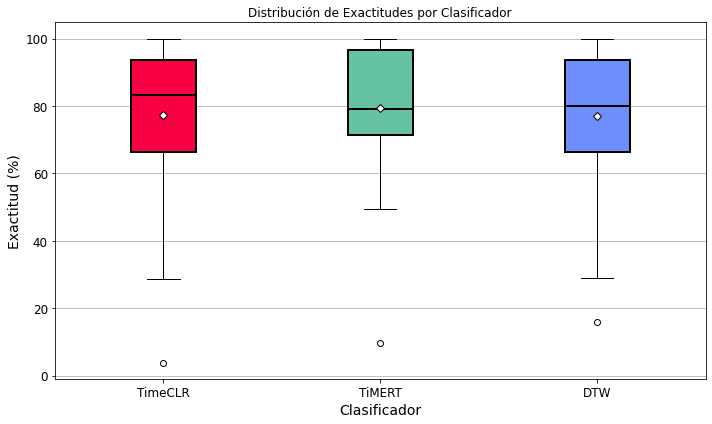

In [157]:
data = [merged_df["TimeCLR"], merged_df["TiMERT"], merged_df["DTW"]]
labels = ['TimeCLR', 'TiMERT', 'DTW']
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Configurar estilo de los boxplots
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='white')

# Dibujar boxplot
bp = ax.boxplot(data, patch_artist=True, labels=labels,
                boxprops=boxprops, medianprops=medianprops, showmeans=True, meanprops=meanpointprops)

# Colores personalizados para cada boxplot
colors = ['#F80044', '#66c2a5', '#6d8dfa']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Personalización de ejes y título
ax.set_title('Distribución de Exactitudes por Clasificador')
ax.set_ylabel('Exactitud (%)', fontsize=14)
ax.set_xlabel('Clasificador', fontsize=14)
ax.yaxis.grid(True)  # Agregar cuadrícula horizontal

# Mejorar la apariencia de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Mostrar el gráfico

plt.savefig("std_other_models.png", format='png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [158]:
merged_df

,dataset,TimeCLR,TiMERT,DTW
0,Beef,60.00,50.000000,50.000000
1,Car,75.00,79.166667,66.666667
2,CricketX,65.28,57.692308,77.564103
3,CricketZ,61.11,58.974359,80.128205
4,DiatomSizeReduction,93.75,98.461538,100.000000
5,DistalPhalanxOutlineCorrect,76.14,78.409091,80.681818
6,ECG5000,93.80,94.600000,93.600000
7,FaceFour,90.91,95.652174,91.304348
8,FiftyWords,52.17,66.850829,63.535912
9,FordA,88.82,76.040609,56.751269


In [161]:
# abrir el archivo de especificaciones de ucr
with open('analysis_files/ucr_details.json', 'r') as file:
    data = json.load(file)

# Print the data
print(data)

[{'Dataset_id': '219', '0': '219', 'Dataset': 'AbnormalHeartbeat', '1': 'AbnormalHeartbeat', 'Train_size': '303', '2': '303', 'Test_size': '303', '3': '303', 'Length': '3053', '4': '3053', 'Multivariate_flag': '0', '5': '0', 'Number_of_classes': '5', '6': '5', 'Type': 'AUDIO', '7': 'AUDIO'}, {'Dataset_id': '86', '0': '86', 'Dataset': 'ACSF1', '1': 'ACSF1', 'Train_size': '100', '2': '100', 'Test_size': '100', '3': '100', 'Length': '1460', '4': '1460', 'Multivariate_flag': '0', '5': '0', 'Number_of_classes': '10', '6': '10', 'Type': 'DEVICE', '7': 'DEVICE'}, {'Dataset_id': '1', '0': '1', 'Dataset': 'Adiac', '1': 'Adiac', 'Train_size': '390', '2': '390', 'Test_size': '391', '3': '391', 'Length': '176', '4': '176', 'Multivariate_flag': '0', '5': '0', 'Number_of_classes': '37', '6': '37', 'Type': 'IMAGE', '7': 'IMAGE'}, {'Dataset_id': '87', '0': '87', 'Dataset': 'AllGestureWiimoteX', '1': 'AllGestureWiimoteX', 'Train_size': '300', '2': '300', 'Test_size': '700', '3': '700', 'Length': '0', '

In [162]:
info_df = pd.DataFrame(data)

In [164]:
merged_df = pd.merge(merged_df, info_df, left_on='dataset', right_on='Dataset', how='left')

In [165]:
merged_df.head()

,dataset,TimeCLR,TiMERT,DTW,Dataset_id,0,Dataset,1,Train_size,2,Test_size,3,Length,4,Multivariate_flag,5,Number_of_classes,6,Type,7
0,Beef,60.00,50.000000,50.000000,3,3,Beef,Beef,30,30,30,30,470,470,0,0,5,5,SPECTRO,SPECTRO
1,Car,75.00,79.166667,66.666667,6,6,Car,Car,60,60,60,60,577,577,0,0,4,4,SENSOR,SENSOR
2,CricketX,65.28,57.692308,77.564103,12,12,CricketX,CricketX,390,390,390,390,300,300,0,0,12,12,HAR,HAR
3,CricketZ,61.11,58.974359,80.128205,14,14,CricketZ,CricketZ,390,390,390,390,300,300,0,0,12,12,HAR,HAR
4,DiatomSizeReduction,93.75,98.461538,100.000000,15,15,DiatomSizeReduction,DiatomSizeReduction,16,16,306,306,345,345,0,0,4,4,IMAGE,IMAGE


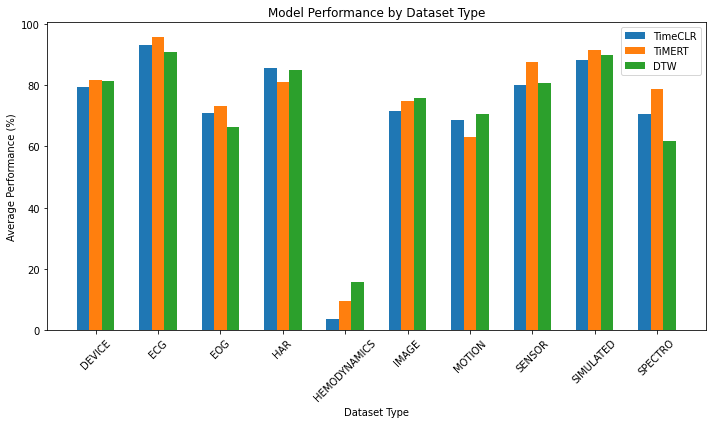

In [166]:
grouped_df = merged_df.groupby('Type').mean()

# Ahora, creamos un gráfico de barras agrupadas para los modelos TimeCLR, TiMERT, y DTW

x = grouped_df.index  # Los tipos de datasets
timeclr_means = grouped_df['TimeCLR']
timert_means = grouped_df['TiMERT']
dtw_means = grouped_df['DTW']

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(x))

bar1 = ax.bar(index, timeclr_means, bar_width, label='TimeCLR')
bar2 = ax.bar([i + bar_width for i in index], timert_means, bar_width, label='TiMERT')
bar3 = ax.bar([i + bar_width*2 for i in index], dtw_means, bar_width, label='DTW')

# Etiquetas y títulos
ax.set_xlabel('Dataset Type')
ax.set_ylabel('Average Performance (%)')
ax.set_title('Model Performance by Dataset Type')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(x, rotation=45)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [167]:
# Paso 1: Identificar el modelo con la puntuación más alta para cada dataset
merged_df['Best_Model'] = merged_df[['TimeCLR', 'TiMERT', 'DTW']].idxmax(axis=1)

In [168]:
# Paso 2: Contar cuántas veces cada modelo fue el mejor para cada tipo de dataset
best_model_count = merged_df.groupby(['Type', 'Best_Model']).size().unstack(fill_value=0)

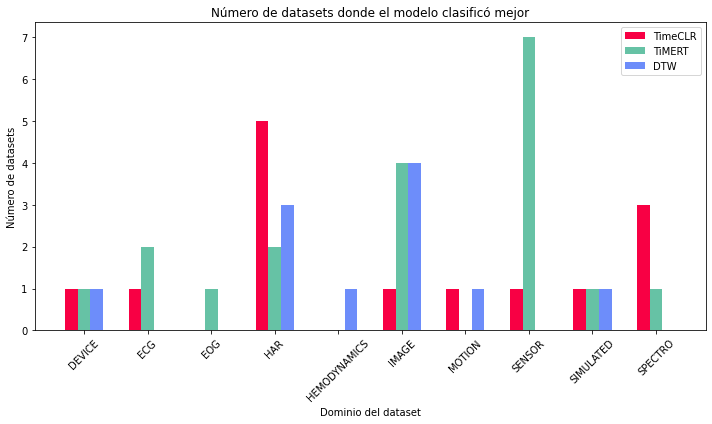

In [169]:
# Paso 3: Graficar los resultados
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(len(best_model_count.index))

colors = ['#F80044', '#66c2a5', '#6d8dfa']

bar1 = ax.bar(index, best_model_count['TimeCLR'], bar_width, label='TimeCLR', color=colors[0])
bar2 = ax.bar([i + bar_width for i in index], best_model_count['TiMERT'], bar_width, label='TiMERT', color=colors[1])
bar3 = ax.bar([i + bar_width*2 for i in index], best_model_count['DTW'], bar_width, label='DTW', color=colors[2])

# Etiquetas y títulos
ax.set_xlabel('Dominio del dataset')
ax.set_ylabel('Número de datasets')
ax.set_title('Número de datasets donde el modelo clasificó mejor')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(best_model_count.index, rotation=45)
ax.legend()

# Mostrar el gráfico
plt.tight_layout()

plt.savefig("models_vs_data_domain.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [170]:
best_model_count

Best_Model,DTW,TiMERT,TimeCLR
Type,,,
DEVICE,1,1,1
ECG,0,2,1
EOG,0,1,0
HAR,3,2,5
HEMODYNAMICS,1,0,0
IMAGE,4,4,1
MOTION,1,0,1
SENSOR,0,7,1
SIMULATED,1,1,1


In [171]:
# Datos de conteos de la tabla que mencionaste
model_counts = {
    'DEVICE': [1, 1, 1],
    'ECG': [0, 2, 1],
    'EOG': [0, 1, 0],
    'HAR': [3, 2, 5],
    'HEMODYNAMICS': [1, 0, 0],
    'IMAGE': [4, 4, 1],
    'MOTION': [1, 0, 1],
    'SENSOR': [0, 7, 1],
    'SIMULATED': [1, 1, 1],
    'SPECTRO': [0, 1, 3]
}

# Convertir a DataFrame
df_counts = pd.DataFrame(model_counts, index=['DTW', 'TiMERT', 'TimeCLR']).T

# Número total de datasets por tipo
total_datasets = {
    'DEVICE': 5,
    'ECG': 5,
    'EOG': 1,
    'HAR': 10,
    'HEMODYNAMICS': 1,
    'IMAGE': 10,
    'MOTION': 5,
    'SENSOR': 10,
    'SIMULATED': 5,
    'SPECTRO': 5
}

# Convertir a DataFrame
df_totals = pd.DataFrame(total_datasets, index=['Total']).T

# Calcular proporciones
df_proportions = df_counts.div(df_totals['Total'], axis=0)

# Mostrar DataFrames para verificar
print("Conteos de los mejores modelos por tipo de dataset:")
print(df_counts)
print("\nNúmero total de datasets por tipo:")
print(df_totals)
print("\nProporciones de los mejores modelos por tipo de dataset:")
print(df_proportions)


Conteos de los mejores modelos por tipo de dataset:
              DTW  TiMERT  TimeCLR
DEVICE          1       1        1
ECG             0       2        1
EOG             0       1        0
HAR             3       2        5
HEMODYNAMICS    1       0        0
IMAGE           4       4        1
MOTION          1       0        1
SENSOR          0       7        1
SIMULATED       1       1        1
SPECTRO         0       1        3

Número total de datasets por tipo:
              Total
DEVICE            5
ECG               5
EOG               1
HAR              10
HEMODYNAMICS      1
IMAGE            10
MOTION            5
SENSOR           10
SIMULATED         5
SPECTRO           5

Proporciones de los mejores modelos por tipo de dataset:
              DTW  TiMERT  TimeCLR
DEVICE        0.2     0.2      0.2
ECG           0.0     0.4      0.2
EOG           0.0     1.0      0.0
HAR           0.3     0.2      0.5
HEMODYNAMICS  1.0     0.0      0.0
IMAGE         0.4     0.4      0.1
MOTI

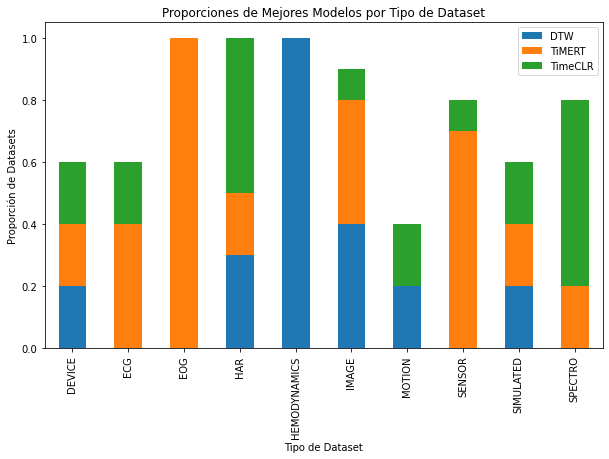

In [172]:
# Graficar las proporciones
df_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proporciones de Mejores Modelos por Tipo de Dataset')
plt.ylabel('Proporción de Datasets')
plt.xlabel('Tipo de Dataset')
plt.show()


In [173]:
# Datos para la prueba de hipótesis
successes_sensor = df_counts.loc['SENSOR', 'TiMERT']
n_sensor = df_totals.loc['SENSOR', 'Total']

successes_others = df_counts.drop('SENSOR').sum()['TiMERT']
n_others = df_totals.drop('SENSOR').sum()['Total']

# Proporciones
p_sensor = successes_sensor / n_sensor
p_others = successes_others / n_others

# Prueba de proporciones
p_pool = (successes_sensor + successes_others) / (n_sensor + n_others)
z_score = (p_sensor - p_others) / (p_pool * (1 - p_pool) * (1/n_sensor + 1/n_others))**0.5
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

print(f"Proporción de éxitos en SENSOR: {p_sensor}")
print(f"Proporción de éxitos en otros tipos de datasets: {p_others}")
print(f"Z-score: {z_score}")
print(f"P-valor: {p_value}")


NameError: name 'stats' is not defined

In [ ]:
dfgdd

In [ ]:
for run in all_runs_exp1[0:1]:
    # Acceder a los atributos de `Run`
    run_id = run.info.run_id
    experiment_id = run.info.experiment_id
    run_name = run.info.run_name
    status = run.info.status
    start_time = run.info.start_time
    end_time = run.info.end_time
    user_id = run.info.user_id

    print("kflsfldjfl", run.data.metrics["test_balanced_accuracy"])

    # Acceder a las métricas
    metrics = run.data.metrics
    for metric_name, metric_value in metrics.items():
        print(f"Metric: {metric_name} = {metric_value}")
    
    # Acceder a los parámetros
    params = run.data.params
    for param_name, param_value in params.items():
        print(f"Param: {param_name} = {param_value}")
    
    # Acceder a los tags
    tags = run.data.tags
    for tag_name, tag_value in tags.items():
        print(f"Tag: {tag_name} = {tag_value}")

    # Acceder a las funciones de pérdida
    metric_history = client.get_metric_history(run_id, "average_loss_validation")
    metric_values = [metric.value for metric in metric_history]
    metric_steps = [metric.step for metric in metric_history]
    for value, step in zip(metric_values, metric_steps):
        print(f"Train_loss: epoca {step}, valor {value}") 
    
    # Información adicional del run
    artifact_uri = run.info.artifact_uri
    print(f"Run ID: {run_id}, Experiment ID: {experiment_id}, Run Name: {run_name}")
    print(f"Status: {status}, Start Time: {start_time}, End Time: {end_time}, User ID: {user_id}")
    print(f"Artifact URI: {artifact_uri}")
    print("-----------")

## Análisis comparativo extendido
Requiere refactorización, este proceso se realizó en otro entorno por la falla del principal

In [179]:
data = {
    "Dataset": [
        "Beef", "Car", "CricketX", "CricketZ", "DiatomSizeReduction",
        "DistalPhalanxOutlineCorrect", "ECG5000", "FaceFour", "FiftyWords",
        "FordA", "GunPoint", "InsectWingbeatSound", "Lightning2", "Meat",
        "MiddlePhalanxOutlineCorrect", "MiddlePhalanxTW", "MoteStrain",
        "NonInvasiveFetalECGThorax1", "OSULeaf", "ShapeletSim", "ShapesAll",
        "SmallKitchenAppliances", "SonyAIBORobotSurface1", "SyntheticControl",
        "ToeSegmentation1", "TwoLeadECG", "UWaveGestureLibraryX", "UWaveGestureLibraryY",
        "Wafer", "Worms", "Crop", "DodgerLoopDay", "DodgerLoopWeekend", "EOGHorizontalSignal",
        "EthanolLevel", "FreezerRegularTrain", "GesturePebbleZ1", "GunPointAgeSpan",
        "GunPointMaleVersusFemale", "GunPointOldVersusYoung", "PigAirwayPressure", "PLAID",
        "SemgHandSubjectCh2", "ShakeGestureWiimoteZ", "UMD"
    ],
    "DTW": [
        60.00, 75.00, 65.28, 61.11, 93.75, 76.14, 93.80, 90.91,
        52.17, 88.82, 100.00, 66.36, 66.67, 50.00, 75.28, 63.64,
        96.06, 85.64, 48.89, 85.00, 73.33, 74.67, 98.39, 96.67,
        85.19, 100.00, 84.82, 75.22, 99.72, 52.00, 71.00, 28.57,
        87.50, 70.83, 80.00, 99.67, 86.21, 97.78, 97.78, 89.13,
        3.85, 63.64, 92.22, 100.00, 83.33
    ],
    "TiMERT": [
        50.00, 79.17, 57.69, 58.97, 98.46, 78.41, 94.60, 95.65,
        66.85, 76.04, 97.50, 64.77, 88.00, 100.00, 83.80, 53.15,
        97.65, 92.43, 49.44, 77.50, 71.67, 71.33, 99.20, 96.67,
        74.07, 100.00, 80.36, 75.00, 99.86, 51.92, 76.17, 59.38,
        100.00, 73.10, 78.11, 99.83, 91.80, 95.60, 98.90, 95.60,
        9.52, 73.95, 86.67, 60.00, 100.00
    ],
    "TimeCLR": [
        50.00, 66.67, 77.56, 80.13, 100.00, 80.68, 93.60, 91.30,
        63.54, 56.75, 92.50, 36.59, 88.00, 95.83, 74.30, 52.25,
        95.69, 78.62, 71.91, 70.00, 77.50, 62.67, 96.00, 99.17,
        81.48, 100.00, 76.34, 62.72, 99.44, 59.62, 70.29, 43.75,
        100.00, 66.21, 28.86, 98.33, 86.89, 93.41, 100.00, 90.11,
        15.87, 83.26, 72.22, 90.00, 100.00
    ]
}
results = pd.DataFrame(data)


In [180]:
#results = pd.DataFrame(data)
tmp = pd.DataFrame(data)

tmp[["DTW", "TiMERT", "TimeCLR"]] = tmp[["DTW", "TiMERT", "TimeCLR"]]/100

tmp.to_csv("analysis_files/tfm.csv") # usado para el marco de trabajo de las pruebas de hipótesis



## Conteos de datasets por modelo

In [181]:
tmp

,Dataset,DTW,TiMERT,TimeCLR
0,Beef,0.6000,0.5000,0.5000
1,Car,0.7500,0.7917,0.6667
2,CricketX,0.6528,0.5769,0.7756
3,CricketZ,0.6111,0.5897,0.8013
4,DiatomSizeReduction,0.9375,0.9846,1.0000
5,DistalPhalanxOutlineCorrect,0.7614,0.7841,0.8068
6,ECG5000,0.9380,0.9460,0.9360
7,FaceFour,0.9091,0.9565,0.9130
8,FiftyWords,0.5217,0.6685,0.6354
9,FordA,0.8882,0.7604,0.5675


In [182]:
def contar_ganadores(row):
    max_score = max(row["DTW"], row["TiMERT"], row["TimeCLR"])
    ganadores = []
    if row["DTW"] == max_score:
        ganadores.append("DTW")
    if row["TiMERT"] == max_score:
        ganadores.append("TiMERT")
    if row["TimeCLR"] == max_score:
        ganadores.append("TimeCLR")
    return ganadores

In [183]:
results["Ganadores"] = results.apply(contar_ganadores, axis=1)

In [184]:
conteo_modelos = results["Ganadores"].explode().value_counts()

In [185]:
conteo_modelos.head()

TiMERT     20
DTW        15
TimeCLR    15
Name: Ganadores, dtype: int64

### Verificación de distancias en los clasificadores

In [186]:
# Calcular la diferencia entre TiMERT y los otros modelos
results["Diferencia vs DTW"] = results["TiMERT"] - results["DTW"]
results["Diferencia vs TimeCLR"] = results["TiMERT"] - results["TimeCLR"]

In [187]:
# Clasificar si TiMERT ganó o perdió en comparación con DTW y TimeCLR
results["Resultado vs DTW"] = results["Diferencia vs DTW"].apply(lambda x: "Ganó" if x > 0 else "Perdió")
results["Resultado vs TimeCLR"] = results["Diferencia vs TimeCLR"].apply(lambda x: "Ganó" if x > 0 else "Perdió")

In [188]:
results.head()

,Dataset,DTW,TiMERT,TimeCLR,Ganadores,Diferencia vs DTW,Diferencia vs TimeCLR,Resultado vs DTW,Resultado vs TimeCLR
0,Beef,60.00,50.00,50.00,[DTW],-10.00,0.00,Perdió,Perdió
1,Car,75.00,79.17,66.67,[TiMERT],4.17,12.50,Ganó,Ganó
2,CricketX,65.28,57.69,77.56,[TimeCLR],-7.59,-19.87,Perdió,Perdió
3,CricketZ,61.11,58.97,80.13,[TimeCLR],-2.14,-21.16,Perdió,Perdió
4,DiatomSizeReduction,93.75,98.46,100.00,[TimeCLR],4.71,-1.54,Ganó,Perdió


In [189]:
# Calcular promedios de las diferencias para victorias y derrotas
promedio_victorias_dtw = results[results["Resultado vs DTW"] == "Ganó"]["Diferencia vs DTW"].mean()
promedio_derrotas_dtw = results[results["Resultado vs DTW"] == "Perdió"]["Diferencia vs DTW"].mean()

promedio_victorias_timeclr = results[results["Resultado vs TimeCLR"] == "Ganó"]["Diferencia vs TimeCLR"].mean()
promedio_derrotas_timeclr = results[results["Resultado vs TimeCLR"] == "Perdió"]["Diferencia vs TimeCLR"].mean()

In [190]:
promedio_victorias_dtw

8.7136

In [191]:
promedio_derrotas_dtw

-6.2545

In [192]:
promedio_victorias_timeclr

9.120000000000001

In [193]:
promedio_derrotas_timeclr

-7.639444444444446

<AxesSubplot: >

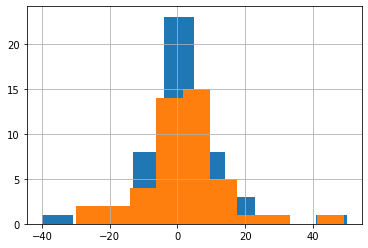

In [194]:
results["Diferencia vs DTW"].hist(bins=10)
results["Diferencia vs TimeCLR"].hist(bins=10)

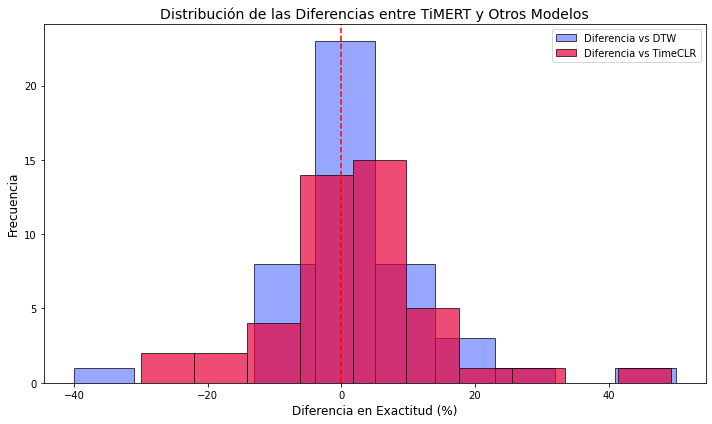

In [195]:
# Crear el gráfico de histogramas
plt.figure(figsize=(10, 6))

# Histograma de las diferencias con DTW
plt.hist(results["Diferencia vs DTW"], bins=10, alpha=0.7, label='Diferencia vs DTW', color='#6b81fe', edgecolor='black')

# Histograma de las diferencias con TimeCLR
plt.hist(results["Diferencia vs TimeCLR"], bins=10, alpha=0.7, label='Diferencia vs TimeCLR', color='#e7003a', edgecolor='black')

# Títulos y etiquetas
plt.title('Distribución de las Diferencias entre TiMERT y Otros Modelos', fontsize=14)
plt.xlabel('Diferencia en Exactitud (%)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Agregar leyenda
plt.legend(loc='upper right')

# Agregar línea vertical en 0 para visualizar victorias y derrotas
plt.axvline(x=0, color='red', linestyle='--', label='Empate')

plt.savefig('histograma_diferencias_TiMERT.png', format='png', dpi=300)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [196]:
results["Diferencia vs TimeCLR"].std()

12.869001566288324

In [197]:
results["Diferencia vs DTW"].std()

12.698131255178351

## extras

In [ ]:
# tiempos de época
#epoch_times = mlflow.get_metric_history(run_id=run_id, key="epoch_time")


In [ ]:
epoch_time_values = [metric.value for metric in epoch_time_history]
#epoch_time_values = [cast_to_datetime(value) for value in epoch_time_values]
epoch_time_steps = [metric.step for metric in epoch_time_history]

In [ ]:
promedio_segs = sum(epoch_time_values) / len(epoch_time_values)

In [ ]:
promedio_segs = cast_to_datetime(promedio_segs)

In [ ]:
promedio_segs.__str__()

In [ ]:
epoch_time_values = [cast_to_datetime(value) for value in epoch_time_values]

In [ ]:
# Graficar tiempo por batch
datetime_objects = [datetime.combine(datetime(1900, 1, 1), t) for t in epoch_time_values]
# Crear la figura y el gráfico
plt.figure(figsize=(10, 5))
# Usar un color cálido (naranja) para la línea
plt.plot(epoch_time_steps, datetime_objects, label="Epoch Time", color="#F80044", linewidth=2, alpha=0.8)  # Coral
# Configurar el eje Y para comenzar en cero y tener intervalos de 15 minutos
plt.gca().yaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Configurar el rango del eje Y
plt.ylim([datetime.combine(datetime(1900, 1, 1), time(0, 0)), 
          datetime.combine(datetime(1900, 1, 1), time(0, 15))])
# Etiquetas y título
plt.xlabel('Epoch/Step')
plt.ylabel('Tiempo (h:mm)')
plt.title('Tiempo por época durante el Entrenamiento')
# Mostrar la cuadrícula para mayor claridad
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Ejemplo de datos (simulados)
epochs = range(1, 21)
train_loss = [0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01, 0.01]
val_loss = [0.7, 0.6, 0.5, 0.45, 0.4, 0.38, 0.36, 0.37, 0.38, 0.4, 0.42, 0.45, 0.48, 0.5, 0.52, 0.54, 0.56, 0.57, 0.58, 0.59]
train_acc = [0.7, 0.75, 0.78, 0.8, 0.82, 0.85, 0.87, 0.89, 0.91, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99]
val_acc = [0.68, 0.72, 0.75, 0.77, 0.78, 0.79, 0.8, 0.78, 0.77, 0.76, 0.74, 0.72, 0.7, 0.68, 0.66, 0.64, 0.62, 0.61, 0.6, 0.59]

# Gráfico de pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Gráfico de exactitud
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
